## USed for merging the 15 attraction dataset containing waiting times

In [88]:
import pandas as pd
import os
import re
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Merge files on Attraction -> output: Each excel for each attraction with cols ('Datetime', 'WaitTime', 'Month', 'Year')
### 0Attraction open
### -1Virtual Queue
### -2Maintenance
###  -3Closed due to weather
### -4Attraction closed
### 91over 90 minutes

### Load data

In [89]:
# Load the merged dataset
try:
    # Try to load the data from the CSV file
    file_path = 'final_df.csv'  # Update this path if your CSV file is located elsewhere
    final_merged = pd.read_csv(file_path)
    
    # Convert Date column to datetime if it exists
    if 'Date' in final_merged.columns:
        final_merged['Date'] = pd.to_datetime(final_merged['Date'])
    
    # Define a function to report missing values
    def report_missing_values(df):
        missing = df.isnull().sum()
        missing_percent = (missing / len(df)) * 100
        missing_stats = pd.DataFrame({
            'Missing Values': missing, 
            'Percentage(%)': missing_percent
        })
        return missing_stats[missing_stats['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
    
    print(f"Data loaded successfully. Shape: {final_merged.shape}")
except FileNotFoundError:
    print(f"Error: File not found. Please check if 'final_df.csv' exists in the current directory.")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully. Shape: (549604, 11)


# Data pre-processing
adding park opening and closing houes based on the information available:
March to NOvember : 9.00 am to 6.00 pm; December- January : 11.00 am to 7.00 pm

In [90]:
import numpy as np

def is_park_open(row):
    # Handle month as int or string
    month = row['Month']
    if isinstance(month, str):
        month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
                     'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
        month = month_map.get(month, None) if not month.isdigit() else int(month)
    # Handle hour extraction robustly
    time_val = row['Time']
    hour = None
    if isinstance(time_val, str):
        try:
            hour = int(time_val.split(':')[0])
        except Exception:
            return 0
    elif not pd.isnull(time_val):
        try:
            hour = pd.to_datetime(time_val).hour
        except Exception:
            return 0
    else:
        return 0
    # Park open logic
    if month is None:
        return 0
    if 3 <= month <= 11:
        return 1 if 9 <= hour < 18 else 0
    elif month in [12, 1]:
        return 1 if 11 <= hour < 19 else 0
    else:
        return 0

final_merged['Park_Open'] = final_merged.apply(is_park_open, axis=1)
print(final_merged['Park_Open'].value_counts())

Park_Open
1    444908
0    104696
Name: count, dtype: int64


# Dataset with where park is opened

In [91]:
# Create a new DataFrame with only park open hours
park_open_df = final_merged[final_merged['Park_Open'] == 1].copy()

# Optional: check the shape or preview
print(park_open_df.shape)
park_open_df.head()

(444908, 12)


,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
9,9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1
10,10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1
11,11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1
12,12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1
13,13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1


In [92]:
#save the DataFrame to a new CSV file
output_file_path = 'park_open_hours.csv'
park_open_df.to_csv(output_file_path, index=False)

### waiting time analysis using special codes for wait time.   
 0= Attraction open 
-1= Virtual Queue
-2= Maintenance
-3 = Closed due to weather
-4= Attraction closed
91over 90 minutes )

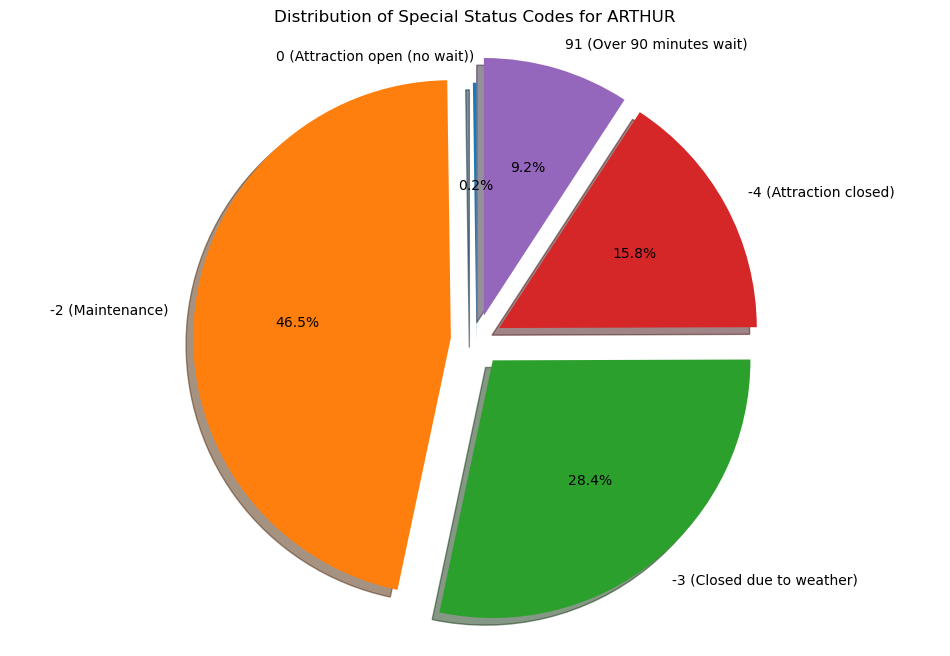

Distribution of special status codes across attractions:


,0 (Attraction open (no wait)),-1 (Virtual Queue),-2 (Maintenance),-3 (Closed due to weather),-4 (Attraction closed),91 (Over 90 minutes wait)
ARTHUR,25 (0.0%),0 (0.0%),5180 (1.2%),3164 (0.7%),1757 (0.4%),1025 (0.2%)


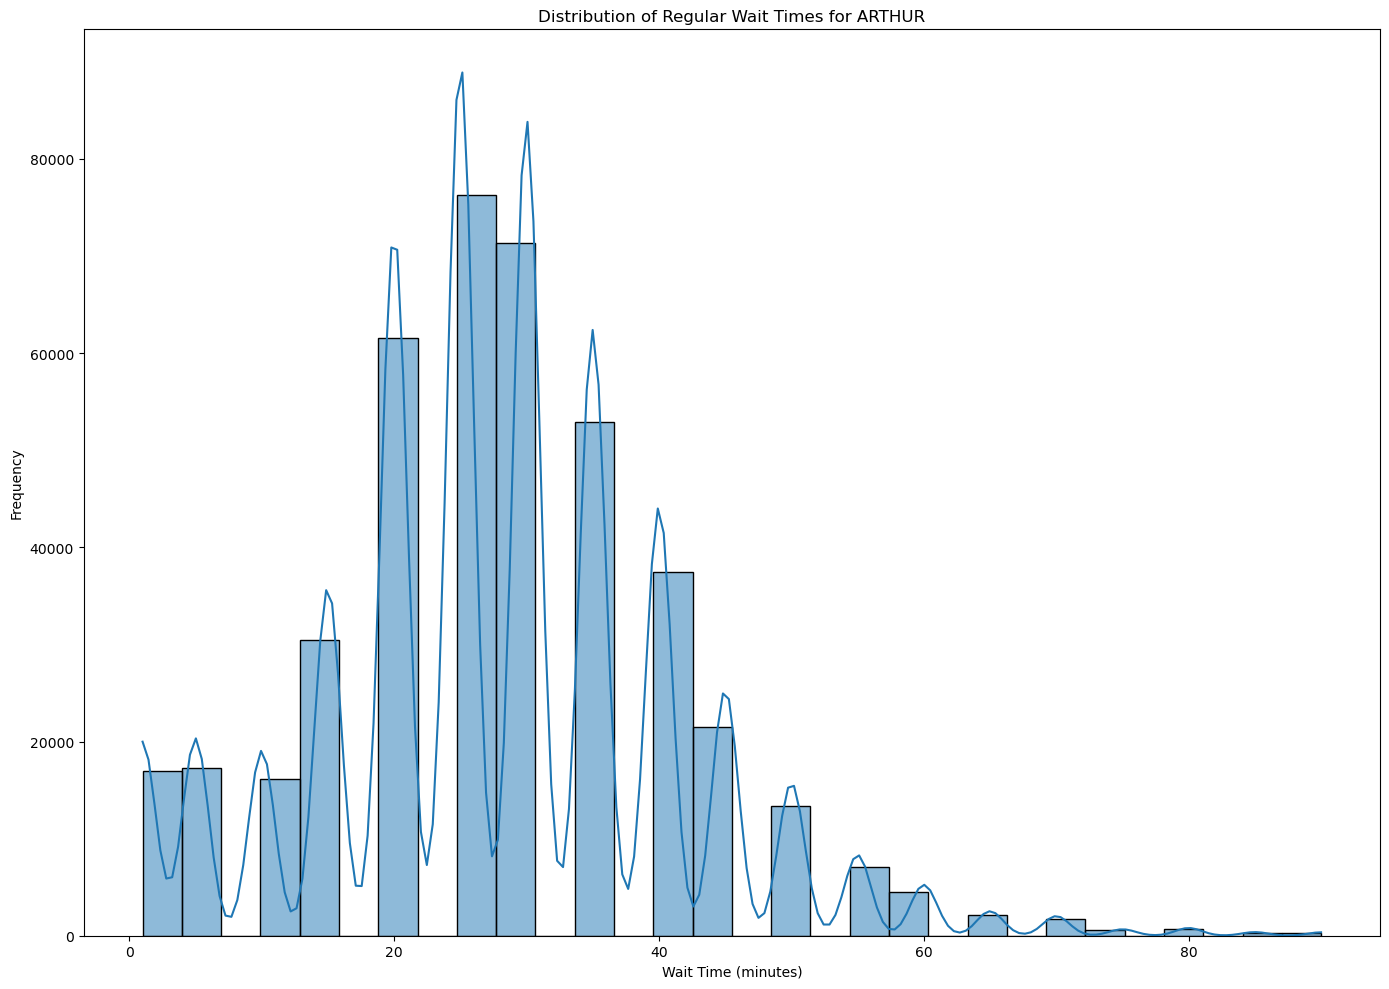

/tmp/ipykernel_360177/3431198905.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


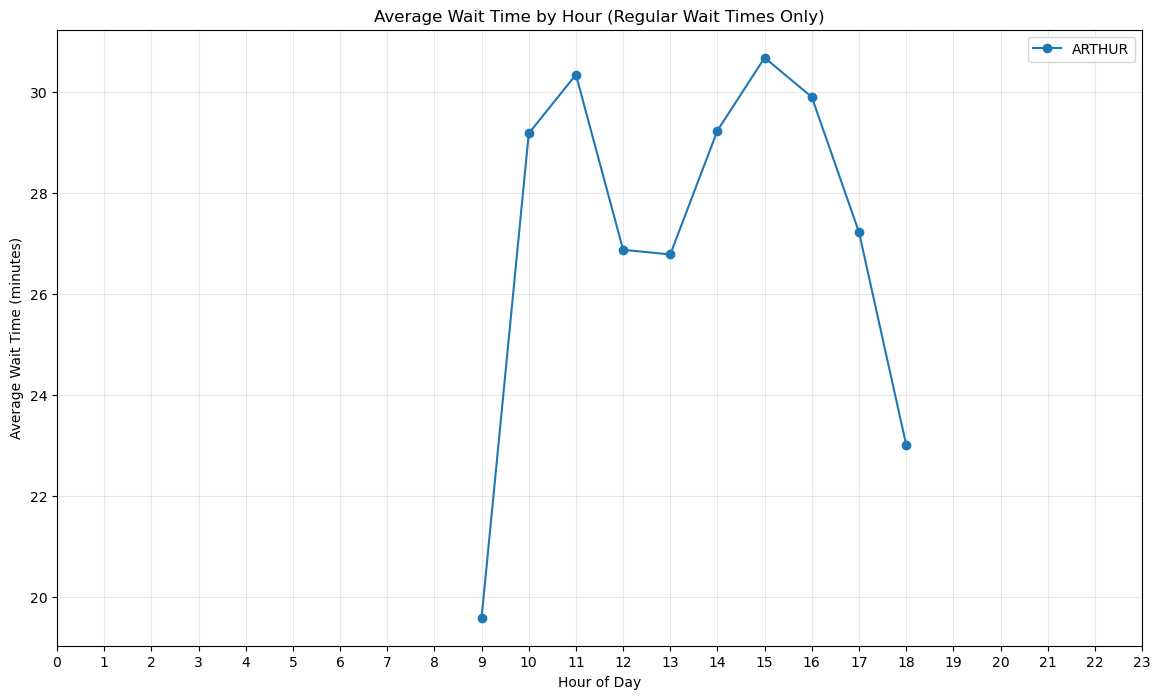

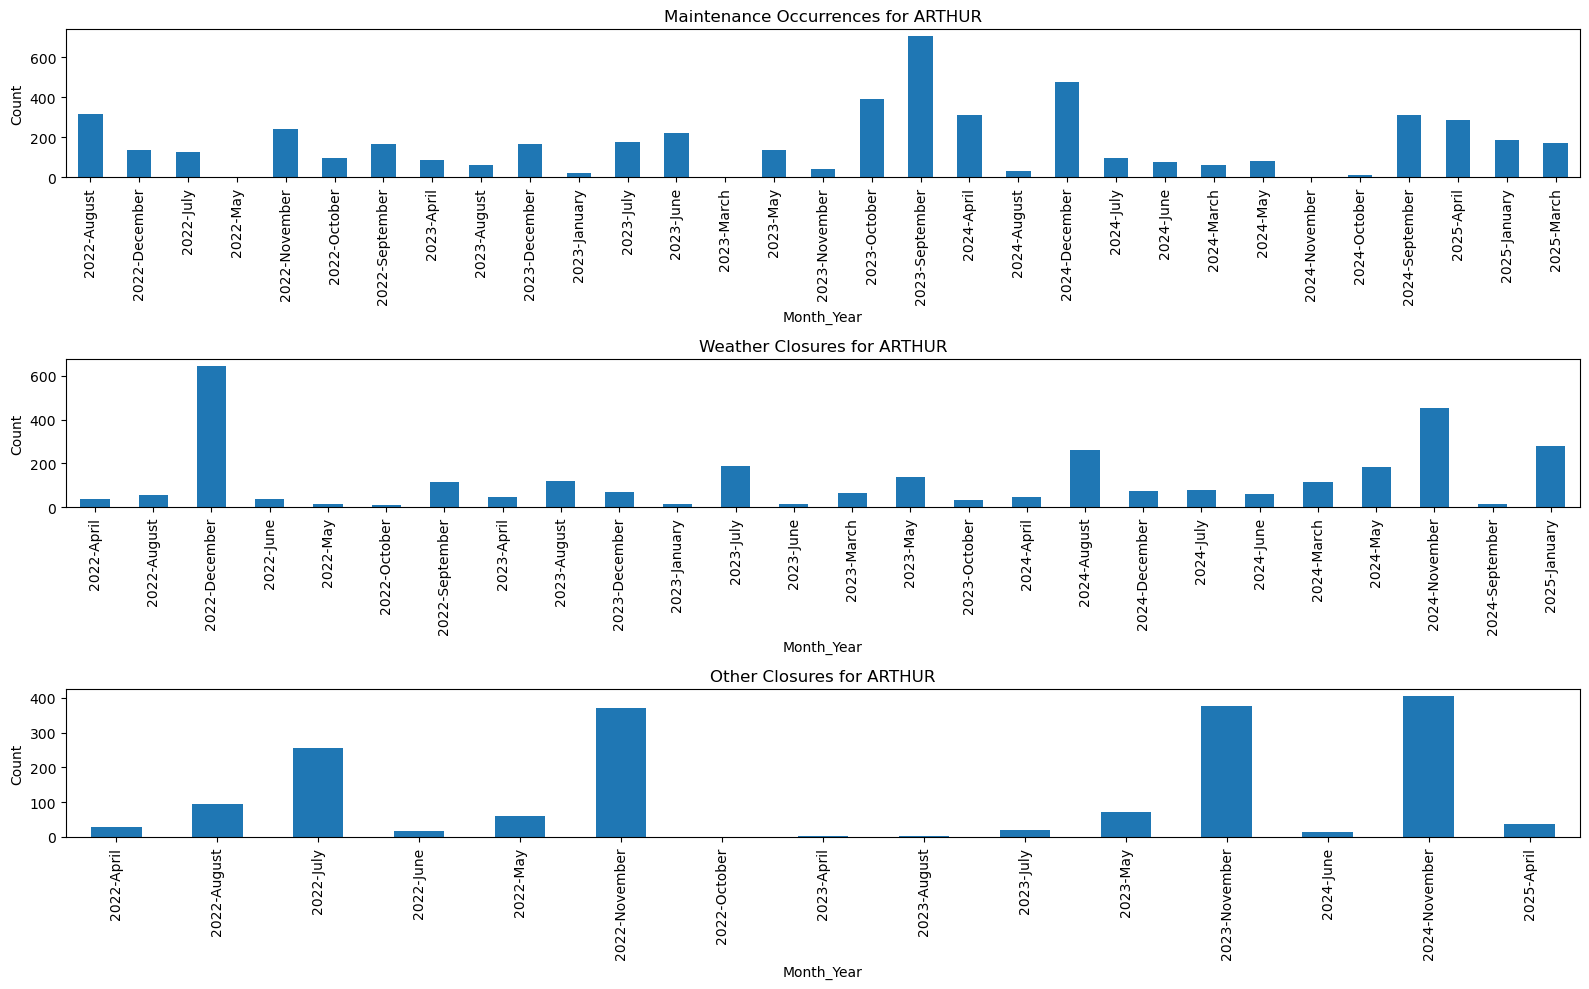

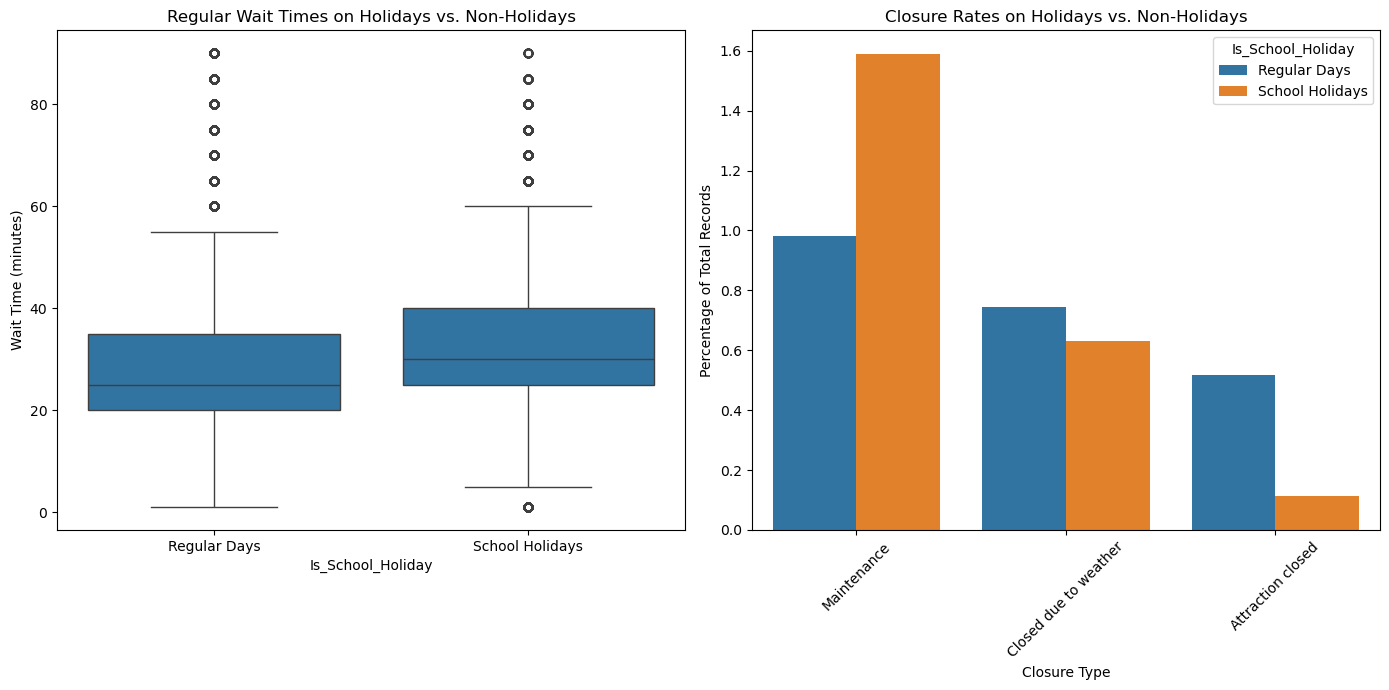

In [93]:
# Analysis of wait time special codes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the meaning of special codes
wait_time_codes = {
    0: "Attraction open (no wait)",
    -1: "Virtual Queue",
    -2: "Maintenance",
    -3: "Closed due to weather",
    -4: "Attraction closed",
    91: "Over 90 minutes wait"
}

# Get all columns with WaitTime in their name
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]

# Function to analyze special codes across all attractions
def analyze_special_codes(df, wait_cols):
    results = {}
    
    for col in wait_cols:
        # Count occurrences of each special code
        special_codes_count = {}
        for code in wait_time_codes.keys():
            count = len(df[df[col] == code])
            if count > 0:
                special_codes_count[code] = count
        
        # Calculate percentages
        total = sum(special_codes_count.values())
        special_codes_percent = {k: (v/df[col].count())*100 for k, v in special_codes_count.items()}
        
        results[col] = {
            'counts': special_codes_count,
            'percentages': special_codes_percent
        }
    
    return results

# Analyze special codes
special_code_analysis = analyze_special_codes(park_open_df, wait_time_columns)

# Create visualization for the first attraction
plt.figure(figsize=(12, 8))

# Select the first wait time column for detailed analysis
first_col = wait_time_columns[0]
attraction_name = first_col.replace('_WaitTime', '')

# Create data for pie chart
labels = [f"{code} ({wait_time_codes[code]})" for code in special_code_analysis[first_col]['counts'].keys()]
sizes = list(special_code_analysis[first_col]['percentages'].values())
explode = [0.1 if code < 0 or code == 91 else 0 for code in special_code_analysis[first_col]['counts'].keys()]

# Plot pie chart
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title(f'Distribution of Special Status Codes for {attraction_name}')
plt.show()

# Table showing special code distributions across all attractions
special_code_table = pd.DataFrame()
for col in wait_time_columns:
    attraction = col.replace('_WaitTime', '')
    counts = special_code_analysis[col]['counts']
    percentages = special_code_analysis[col]['percentages']
    
    for code in wait_time_codes.keys():
        if code in counts:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = f"{counts[code]} ({percentages[code]:.1f}%)"
        else:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = "0 (0.0%)"

print("Distribution of special status codes across attractions:")
display(special_code_table)

# Analysis of regular wait times (positive values excluding 91)
plt.figure(figsize=(14, 10))
for i, col in enumerate(wait_time_columns[:min(len(wait_time_columns), 5)]):  # Limit to first 5 attractions
    # Filter for regular wait times (positive, excluding 91)
    wait_data = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)][col]
    
    plt.subplot(min(len(wait_time_columns), 5), 1, i+1)
    sns.histplot(wait_data, kde=True, bins=30)
    plt.title(f'Distribution of Regular Wait Times for {col.replace("_WaitTime", "")}')
    plt.xlabel('Wait Time (minutes)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Average wait times by hour of day (ignoring special codes)
if 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    try:
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    plt.figure(figsize=(14, 8))
    
    # Plot for up to 5 attractions
    for col in wait_time_columns[:min(len(wait_time_columns), 5)]:
        # Filter regular wait times
        filtered_df = df_time[(df_time[col] > 0) & (df_time[col] != 91)]
        hourly_avg = filtered_df.groupby('Hour')[col].mean().reset_index()
        
        plt.plot(hourly_avg['Hour'], hourly_avg[col], marker='o', label=col.replace('_WaitTime', ''))
    
    plt.title('Average Wait Time by Hour (Regular Wait Times Only)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Seasonal patterns in special codes
if 'Month' in park_open_df.columns and 'Year' in park_open_df.columns:
    plt.figure(figsize=(16, 10))
    
    # Create month-year column
    park_open_df['Month_Year'] = park_open_df['Year'].astype(str) + '-' + park_open_df['Month'].astype(str)
    
    # Focus on the first attraction
    col = wait_time_columns[0]
    
    # Track maintenance and weather closure over time
    maintenance = park_open_df[park_open_df[col] == -2].groupby('Month_Year').size()
    weather = park_open_df[park_open_df[col] == -3].groupby('Month_Year').size()
    closed = park_open_df[park_open_df[col] == -4].groupby('Month_Year').size()
    
    # Plot
    plt.subplot(3, 1, 1)
    maintenance.plot(kind='bar')
    plt.title(f'Maintenance Occurrences for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 2)
    weather.plot(kind='bar')
    plt.title(f'Weather Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 3)
    closed.plot(kind='bar')
    plt.title(f'Other Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Impact of holidays on wait times vs closure rates
if 'Is_School_Holiday' in park_open_df.columns:
    plt.figure(figsize=(14, 7))
    
    # Analyze first attraction
    col = wait_time_columns[0]
    
    # Regular wait times on holidays vs. non-holidays
    wait_holiday = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 1)][col]
    wait_regular = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 0)][col]
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Is_School_Holiday', y=col, 
                data=park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)])
    plt.title(f'Regular Wait Times on Holidays vs. Non-Holidays')
    plt.xticks([0, 1], ['Regular Days', 'School Holidays'])
    plt.ylabel('Wait Time (minutes)')
    
    # Closure rates on holidays vs. non-holidays
    closure_data = []
    
    for holiday in [0, 1]:
        holiday_df = park_open_df[park_open_df['Is_School_Holiday'] == holiday]
        total = len(holiday_df)
        for code in [-2, -3, -4]:  # Maintenance, Weather, Closed
            count = len(holiday_df[holiday_df[col] == code])
            closure_data.append({
                'Is_School_Holiday': 'School Holidays' if holiday == 1 else 'Regular Days',
                'Closure Type': wait_time_codes[code],
                'Percentage': (count/total)*100 if total > 0 else 0
            })
    
    closure_df = pd.DataFrame(closure_data)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Closure Type', y='Percentage', hue='Is_School_Holiday', data=closure_df)
    plt.title('Closure Rates on Holidays vs. Non-Holidays')
    plt.ylabel('Percentage of Total Records')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

#EDA

In [94]:
park_open_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 444908 entries, 9 to 549587
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Unnamed: 0                444908 non-null  int64         
 1   ARTHUR_WaitTime           443594 non-null  float64       
 2   Month                     444908 non-null  object        
 3   Year                      444908 non-null  int64         
 4   Date                      444908 non-null  datetime64[ns]
 5   Time                      444908 non-null  object        
 6   temperature_in_celsius    375601 non-null  float64       
 7   precipitation_in_percent  375601 non-null  float64       
 8   wind_speed_in_kmh         375601 non-null  float64       
 9   Is_School_Holiday         444908 non-null  int64         
 10  Is_Public_Holiday         444908 non-null  int64         
 11  Park_Open                 444908 non-null  int64         
 12  Month_Y

In [95]:
park_open_df.head()


,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open,Month_Year
9,9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1,2022-April
10,10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1,2022-April
11,11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1,2022-April
12,12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1,2022-April
13,13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1,2022-April


In [96]:
park_open_df.tail()


,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open,Month_Year
549583,549583,5.0,March,2025,2025-03-31,17:55,12.1,10.0,15.0,0,0,1,2025-March
549584,549584,5.0,March,2025,2025-03-31,17:56,12.1,10.0,15.0,0,0,1,2025-March
549585,549585,5.0,March,2025,2025-03-31,17:57,12.0,10.0,15.0,0,0,1,2025-March
549586,549586,5.0,March,2025,2025-03-31,17:58,12.0,10.0,15.0,0,0,1,2025-March
549587,549587,5.0,March,2025,2025-03-31,17:59,12.0,10.0,15.0,0,0,1,2025-March


In [97]:
park_open_df.shape

(444908, 13)

In [98]:
park_open_df.describe()

,Unnamed: 0,ARTHUR_WaitTime,Year,Date,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
count,444908.000000,443594.000000,444908.000000,444908,375601.000000,375601.000000,375601.000000,444908.000000,444908.000000,444908.0
mean,275022.903369,27.313438,2023.230349,2023-10-26 20:59:33.297850112,15.892425,26.824223,14.310825,0.301912,0.028129,1.0
min,9.000000,-4.000000,2022.000000,2022-04-01 00:00:00,-8.100000,0.000000,5.000000,0.000000,0.000000,1.0
25%,136646.750000,20.000000,2023.000000,2023-01-07 00:00:00,10.300000,10.000000,5.000000,0.000000,0.000000,1.0
50%,274535.500000,25.000000,2023.000000,2023-10-11 00:00:00,15.800000,30.000000,10.000000,0.000000,0.000000,1.0
75%,413299.250000,35.000000,2024.000000,2024-07-24 00:00:00,21.800000,30.000000,15.000000,1.000000,0.000000,1.0
max,549587.000000,91.000000,2025.000000,2025-04-30 00:00:00,36.300000,95.000000,65.000000,1.000000,1.000000,1.0
std,158657.790389,14.379417,0.889358,NaN,7.674387,19.410630,11.720439,0.459088,0.165343,0.0


In [99]:
park_open_df.describe(include='all')

,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open,Month_Year
count,444908.000000,443594.000000,444908,444908.000000,444908,444908,375601.000000,375601.000000,375601.000000,444908.000000,444908.000000,444908.0,444908
unique,NaN,NaN,11,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,34
top,NaN,NaN,April,NaN,NaN,11:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-July
freq,NaN,NaN,51811,NaN,NaN,911,NaN,NaN,NaN,NaN,NaN,NaN,16740
mean,275022.903369,27.313438,NaN,2023.230349,2023-10-26 20:59:33.297850112,NaN,15.892425,26.824223,14.310825,0.301912,0.028129,1.0,NaN
min,9.000000,-4.000000,NaN,2022.000000,2022-04-01 00:00:00,NaN,-8.100000,0.000000,5.000000,0.000000,0.000000,1.0,NaN
25%,136646.750000,20.000000,NaN,2023.000000,2023-01-07 00:00:00,NaN,10.300000,10.000000,5.000000,0.000000,0.000000,1.0,NaN
50%,274535.500000,25.000000,NaN,2023.000000,2023-10-11 00:00:00,NaN,15.800000,30.000000,10.000000,0.000000,0.000000,1.0,NaN
75%,413299.250000,35.000000,NaN,2024.000000,2024-07-24 00:00:00,NaN,21.800000,30.000000,15.000000,1.000000,0.000000,1.0,NaN
max,549587.000000,91.000000,NaN,2025.000000,2025-04-30 00:00:00,NaN,36.300000,95.000000,65.000000,1.000000,1.000000,1.0,NaN


In [100]:
report_missing_values(park_open_df)

,Missing Values,Percentage(%)
temperature_in_celsius,69307,15.577827
precipitation_in_percent,69307,15.577827
wind_speed_in_kmh,69307,15.577827
ARTHUR_WaitTime,1314,0.295342


### Data visualization

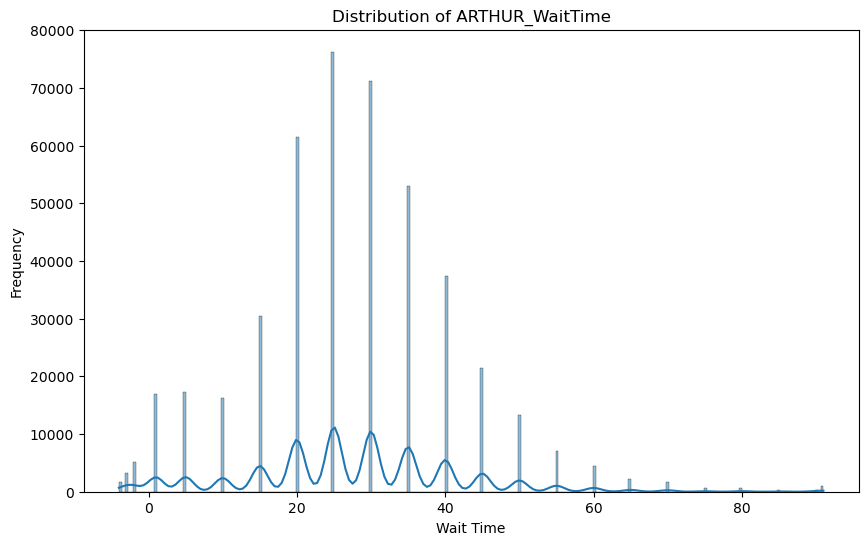

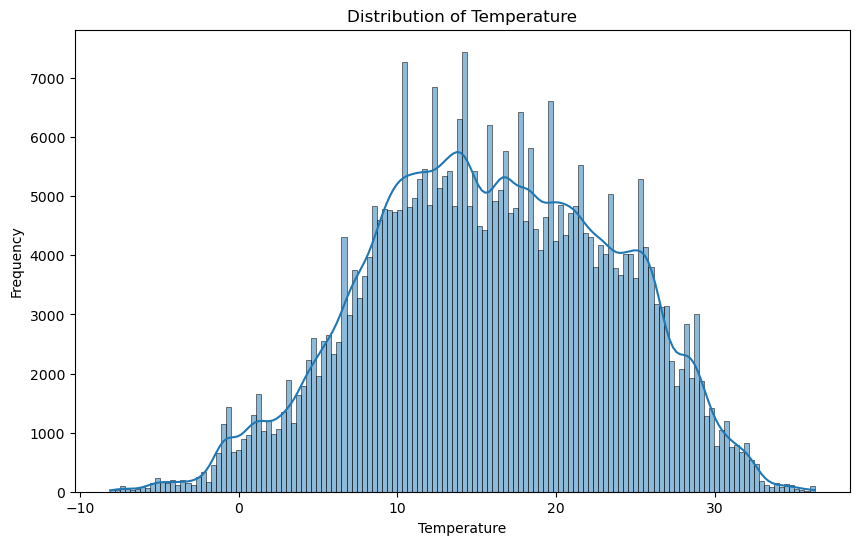

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
# filepath: /home/ms/hfu/ML/ML_Presentation_Workspace/merge_df.ipynb
# Add to a new cell
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Histogram for a wait time column (replace with an actual column name)
# Identify wait time columns first
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df[wait_time_columns[0]].dropna(), kde=True)
    plt.title(f'Distribution of {wait_time_columns[0]}')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No wait time columns found to plot.")


# Example: Histogram for Temperature (if 'Temperature' column exists)
if 'temperature_in_celsius' in park_open_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df['temperature_in_celsius'].dropna(), kde=True)
    plt.title('Distribution of Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()
elif 'temp_value' in park_open_df.columns: # Based on your merge_fn_wind_prec_temp
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df['temp_value'].dropna(), kde=True)
    plt.title('Distribution of Temperature (temp_value)')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No 'Temperature' or 'temp_value' column found to plot.")



### Exploring Relationships Between Variables
Let's examine how different variables relate to each other, particularly how weather conditions, holidays, and other factors might affect wait times.

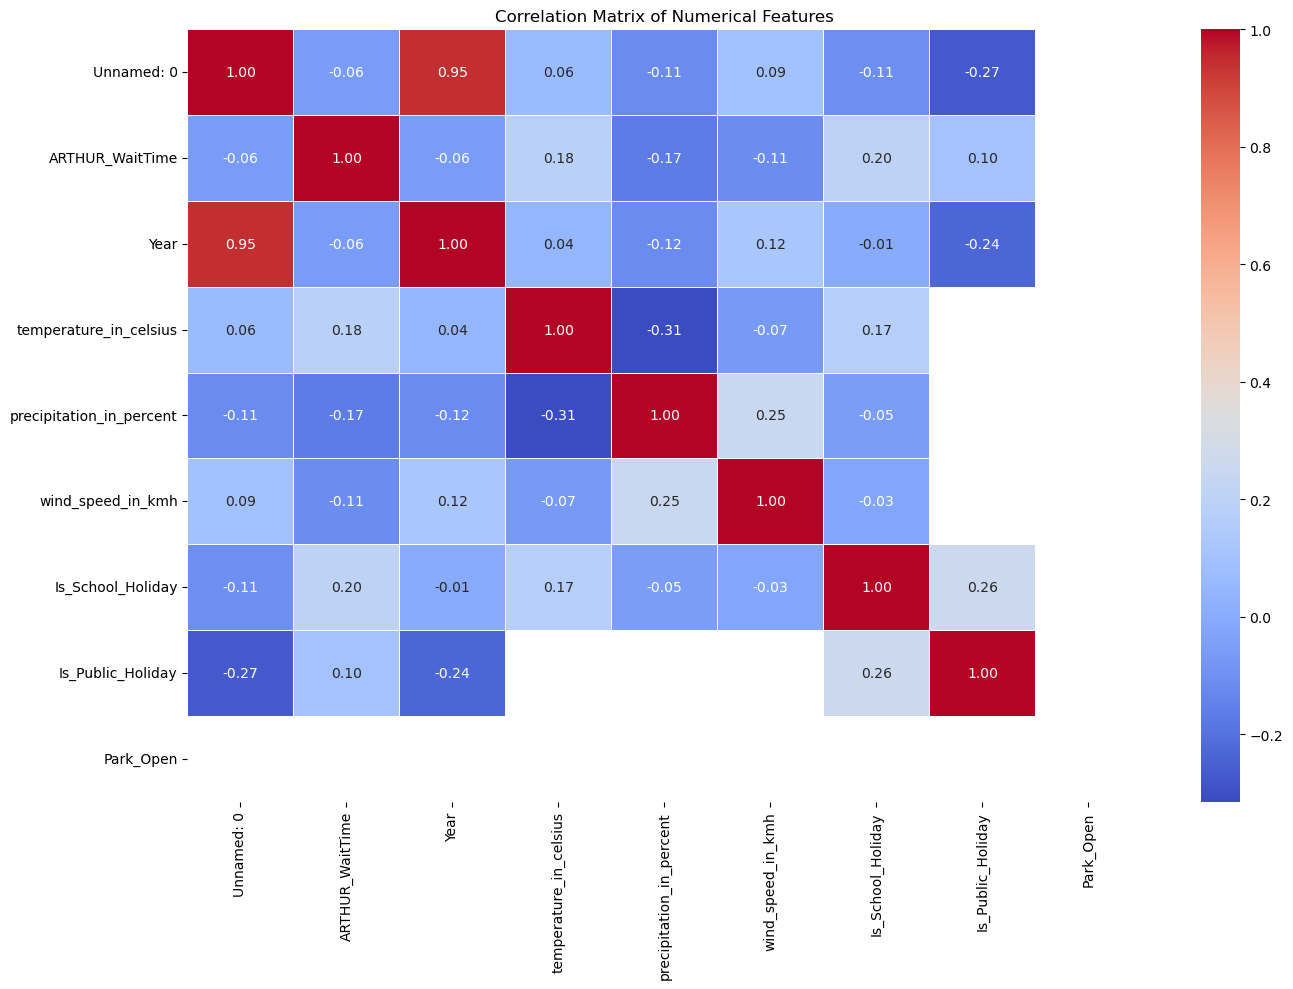

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation analysis
# First, identify the numeric columns in the dataframe
numeric_cols = park_open_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove unnecessary numeric columns (like index) if they exist
exclude_cols = []  # Add columns to exclude if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create a correlation matrix for these numeric columns
if numeric_cols:
    correlation_matrix = park_open_df[numeric_cols].corr(method='pearson', numeric_only=True)
    
    # Plot the correlation matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for correlation analysis")

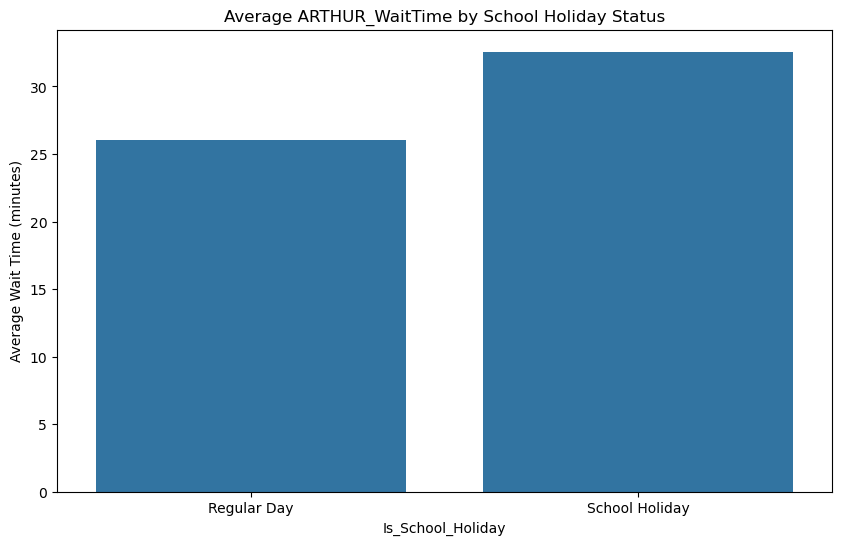

Wait time statistics by school holiday status:
  Is_School_Holiday       mean  median        std
0       Regular Day  26.033911    25.0  14.046067
1    School Holiday  32.585196    30.0  11.986352


In [103]:
# Explore relationship between wait time and holidays
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns and 'Is_School_Holiday' in park_open_df.columns:
    # Pick a representative wait time column
    wait_col = wait_time_columns[0]
    
    # Filter out values < 0 (probably maintenance or closed)
    df_filtered = park_open_df[park_open_df[wait_col] >= 0].copy()
    
    # Calculate average wait time on school holidays vs regular days
    avg_by_holiday = df_filtered.groupby('Is_School_Holiday')[wait_col].agg(['mean', 'median', 'std']).reset_index()
    avg_by_holiday['Is_School_Holiday'] = avg_by_holiday['Is_School_Holiday'].map({0: 'Regular Day', 1: 'School Holiday'})
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Is_School_Holiday', y='mean', data=avg_by_holiday)
    plt.title(f'Average {wait_col} by School Holiday Status')
    plt.ylabel('Average Wait Time (minutes)')
    plt.show()
    
    print(f"Wait time statistics by school holiday status:\n{avg_by_holiday}")

/tmp/ipykernel_360177/480812707.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


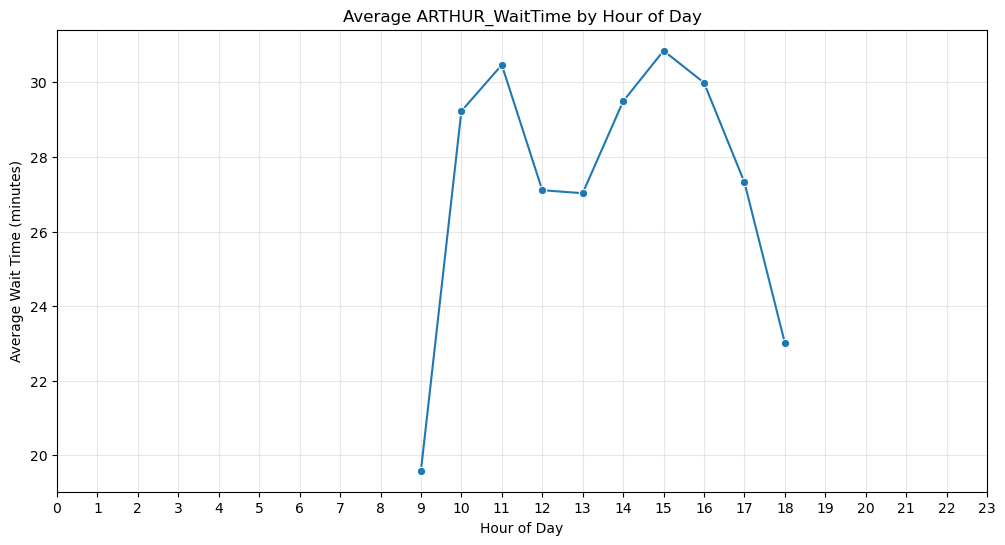

In [104]:
# Explore wait time by time of day
if wait_time_columns and 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    try:
        # Try to extract hour directly if Time is already properly formatted
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        # If that fails, try a different approach assuming 'Time' is a string like '10:30'
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    # Filter out negative wait times
    wait_col = wait_time_columns[0]
    df_time = df_time[df_time[wait_col] >= 0]
    
    # Group by hour and calculate average wait time
    hourly_avg = df_time.groupby('Hour')[wait_col].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y=wait_col, data=hourly_avg, marker='o')
    plt.title(f'Average {wait_col} by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.show()

In [105]:
# Explore the relationship between weather and wait times
if wait_time_columns and 'temp_value' in park_open_df.columns:
    wait_col = wait_time_columns[0]
    df_filtered = park_open_df[(park_open_df[wait_col] >= 0) & (~park_open_df['temp_value'].isna())].copy()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='temp_value', y=wait_col, data=df_filtered, alpha=0.5)
    plt.title(f'Relationship Between Temperature and {wait_col}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Wait Time (minutes)')
    
    # Add a trend line
    sns.regplot(x='temp_value', y=wait_col, data=df_filtered, scatter=False, color='red')
    plt.show()
    
    # Calculate correlation
    correlation = df_filtered[['temp_value', wait_col]].corr().iloc[0, 1]
    print(f"Correlation between temperature and {wait_col}: {correlation:.3f}")

### Forecasting using Differencing with Linear Regression

This approach aims to forecast the change in waiting times instead of their absolute values. By differencing the time series, seasonalities and trends can be removed, often making the series more stationary and easier to model with simpler algorithms like Linear Regression. The final prediction is then reconstructed by adding the predicted difference to the last known actual value.

In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Select the main attraction wait time for forecasting
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if not wait_time_columns:
    raise ValueError("No wait time columns found in the dataset")

# For this example, we'll use the first wait time column (ARTHUR_WaitTime)
target_column = wait_time_columns[0]
print(f"Selected target column for forecasting: {target_column}")

# Phase 1: Data Preparation and Feature Engineering
# ------------------------------------------------

# 1. Initial preprocessing
# Create a copy to avoid modifying the original dataframe
df_forecast = park_open_df.copy()

# Convert Date to datetime if it's not already
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Create a DateTime column combining Date and Time
df_forecast['DateTime'] = pd.to_datetime(df_forecast['Date'].astype(str) + ' ' + df_forecast['Time'])

# Sort by DateTime to ensure chronological order
df_forecast = df_forecast.sort_values('DateTime').reset_index(drop=True)

# Handle missing or negative values in target column (these could be maintenance periods)
df_forecast = df_forecast[df_forecast[target_column] >= 0].copy()

# 2. Generate Original Lag1 (for Reconstruction)
df_forecast[f'{target_column}_lag1_original'] = df_forecast[target_column].shift(1)

# 3. Calculate Differenced Series
df_forecast[f'{target_column}_diff'] = df_forecast[target_column] - df_forecast[f'{target_column}_lag1_original']

# 4. Handle NaNs from Differencing/Lagging
df_forecast = df_forecast.dropna(subset=[f'{target_column}_diff', f'{target_column}_lag1_original'])

# 5. Generate Lag Features for Differenced Series
df_forecast[f'{target_column}_diff_lag1'] = df_forecast[f'{target_column}_diff'].shift(1)
df_forecast[f'{target_column}_diff_lag2'] = df_forecast[f'{target_column}_diff'].shift(2)

# 6. Extract Time-Based Features
df_forecast['hour_of_day'] = df_forecast['DateTime'].dt.hour
df_forecast['day_of_week'] = df_forecast['DateTime'].dt.dayofweek
df_forecast['day_of_year'] = df_forecast['DateTime'].dt.dayofyear
df_forecast['month'] = df_forecast['DateTime'].dt.month
df_forecast['is_weekend'] = df_forecast['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_forecast['minute_of_hour'] = df_forecast['DateTime'].dt.minute

# 7. Drop rows with NaNs in feature columns
df_forecast = df_forecast.dropna(subset=[f'{target_column}_diff_lag1', f'{target_column}_diff_lag2'])

# Feature columns for the model
feature_columns = [
    f'{target_column}_diff_lag1', 
    f'{target_column}_diff_lag2',
    'hour_of_day',
    'day_of_week',
    'day_of_year',
    'month',
    'is_weekend',
    'minute_of_hour'
]

# Add holiday features if they exist
if 'Is_School_Holiday' in df_forecast.columns:
    feature_columns.append('Is_School_Holiday')
if 'Is_Public_Holiday' in df_forecast.columns:
    feature_columns.append('Is_Public_Holiday')
    
# Add weather features if they exist
weather_cols = ['temp_value', 'precipitation_in_percent', 'wind_speed_in_kmh']
for col in weather_cols:
    if col in df_forecast.columns:
        feature_columns.append(col)

# Define Features (X) and Labels (y)
X = df_forecast[feature_columns]
y = df_forecast[f'{target_column}_diff']  # Target is the differenced series

Selected target column for forecasting: ARTHUR_WaitTime



Mean Absolute Error for Differenced Linear Regression: 0.30 minutes
Mean Absolute Error for Persistence Baseline: 0.25 minutes
Improvement over persistence baseline: -16.55%


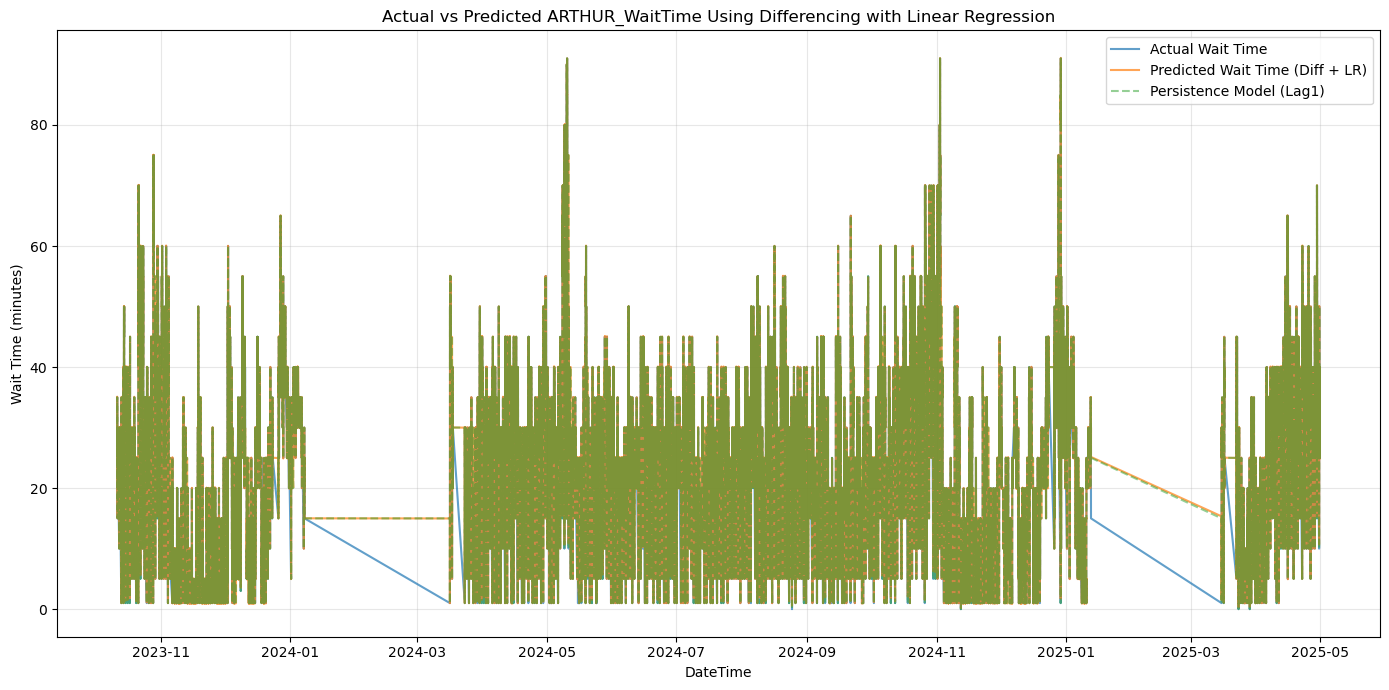

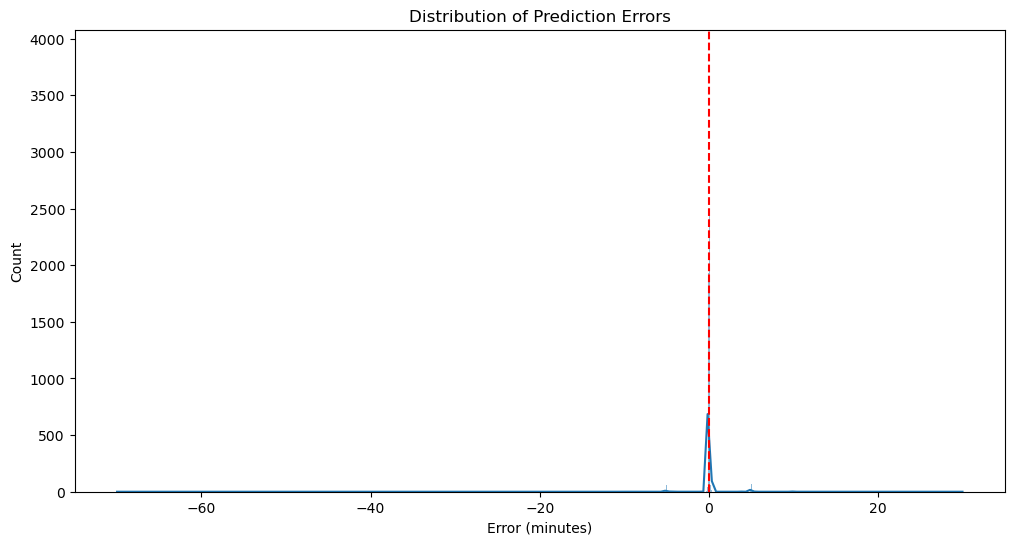


Error Statistics:
Mean error: 0.00 minutes
Standard deviation of error: 1.51 minutes
Median error: 0.00 minutes


In [107]:
# Phase 2: Model Training and Prediction
# -------------------------------------

# 1. Data Splitting
test_size = 0.5  # Using 50% for testing as specified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# Save the indices for later reference
train_indices = X_train.index
test_indices = X_test.index

# 2. Handle missing values in features (impute with column mean)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use train mean for test set

# 3. Model Initialization
model = LinearRegression()

# 3. Model Training
model.fit(X_train, y_train)

# 4. Prediction of Differences
y_pred_diff = model.predict(X_test)

# Phase 3: Reconstruction and Evaluation
# ------------------------------------

# 1. Reconstruction of Total Wait Times
# Get original lag1 values for test set
original_lag1_test = df_forecast.loc[test_indices, f'{target_column}_lag1_original']

# Reconstruct the absolute wait times by adding predicted differences to the lag1 values
y_pred_reconstructed = original_lag1_test.values + y_pred_diff

# 2. Model Performance Metric
# Get actual wait times from the test set for comparison
y_true = df_forecast.loc[test_indices, target_column].values

# Calculate MAE for the differenced model
mae_diff_model = mean_absolute_error(y_true, y_pred_reconstructed)
print(f"\nMean Absolute Error for Differenced Linear Regression: {mae_diff_model:.2f} minutes")

# 3. Persistence Baseline (Original Values)
# Persistence model simply uses the last known value (lag1) as the prediction
mae_persistence = mean_absolute_error(y_true, original_lag1_test.values)
print(f"Mean Absolute Error for Persistence Baseline: {mae_persistence:.2f} minutes")

# 4. Comparison and Interpretation
improvement = (mae_persistence - mae_diff_model) / mae_persistence * 100
print(f"Improvement over persistence baseline: {improvement:.2f}%")

# 5. Visualizations
plt.figure(figsize=(14, 7))
plt.plot(df_forecast.loc[test_indices, 'DateTime'], y_true, label='Actual Wait Time', alpha=0.7)
plt.plot(df_forecast.loc[test_indices, 'DateTime'], y_pred_reconstructed, 
         label='Predicted Wait Time (Diff + LR)', alpha=0.7)
plt.plot(df_forecast.loc[test_indices, 'DateTime'], original_lag1_test, 
         label='Persistence Model (Lag1)', alpha=0.5, linestyle='--')

plt.title(f'Actual vs Predicted {target_column} Using Differencing with Linear Regression')
plt.xlabel('DateTime')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the distribution of prediction errors
plt.figure(figsize=(12, 6))
errors = y_true - y_pred_reconstructed
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (minutes)')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

print(f"\nError Statistics:")
print(f"Mean error: {np.mean(errors):.2f} minutes")
print(f"Standard deviation of error: {np.std(errors):.2f} minutes")
print(f"Median error: {np.median(errors):.2f} minutes")

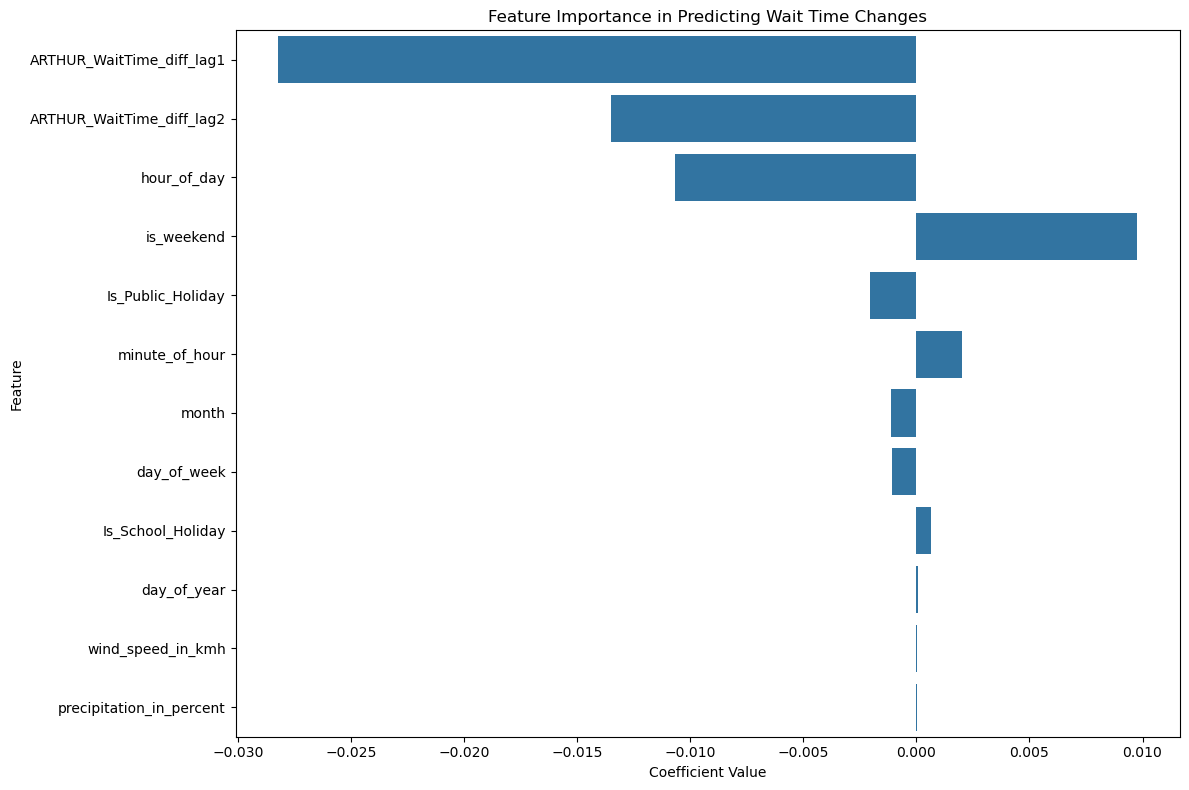

Top 5 most important features:
                     Feature  Importance
0  ARTHUR_WaitTime_diff_lag1   -0.028226
1  ARTHUR_WaitTime_diff_lag2   -0.013519
2                hour_of_day   -0.010686
6                 is_weekend    0.009759
9          Is_Public_Holiday   -0.002071


In [108]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.coef_
})

feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Predicting Wait Time Changes')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(feature_importance.head(5))